In [249]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [123]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'r_rcs_flux_corr',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [124]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")

In [125]:
list(data.columns)

['Source_Name',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'S_Code',
 'EBV',
 'FUV_flux_corr',
 'FUV_fluxerr_corr',
 'NUV_flux_corr',
 'NUV_fluxerr_corr',
 'u_flux_corr',
 'u_fluxerr_corr',
 'Bw_flux_corr',
 'Bw_fluxerr_corr',
 'R_flux_corr',
 'R_fluxerr_corr',
 'I_flux_corr',
 'I_fluxerr_corr',
 'z_flux_corr',
 'z_fluxerr_corr',
 'z_Subaru_flux_corr',
 'z_Subaru_fluxerr_corr',
 'y_flux_corr',
 'y_fluxerr_corr',
 'J_flux_corr',
 'J_fluxerr_corr',
 'H_flux_corr',
 'H_fluxerr_corr',
 'K_flux_corr',
 'K_fluxerr_corr',
 'Ks_flux_corr',
 'Ks_fluxerr_corr',
 'ch1_flux_corr',
 'ch1_fluxerr_corr',
 'ch2_flux_corr',
 'ch2_fluxerr_corr',
 'ch3_flux_corr',
 'ch3_fluxerr_corr',
 'ch4_flux_corr',
 'ch4_fluxerr_corr',
 'F_MIPS_24',
 'FErr_MIPS_24_u',
 'FErr_MIPS_24_l',
 'F_PACS_100',
 'FErr_PACS_100_u',
 'FErr_PACS_100_l',
 'F_PACS_160',
 'FErr_PACS_160_u',
 'FErr_PACS_160_l',
 'F_SPIRE_250',
 'FErr_SPIRE_250_u',
 'FErr_SPIRE_250_l',
 'F_SPIRE_350',
 'FErr_SPIRE_350_u',
 'FErr_SP

In [126]:
data.isna().sum()

Source_Name               0
Total_flux                0
E_Total_flux              0
Peak_flux                 0
E_Peak_flux               0
                      ...  
g_rcs_flux_corr       23871
g_rcs_fluxerr_corr    50430
r_rcs_fluxerr_corr    50436
i_rcs_fluxerr_corr    50447
z_rcs_fluxerr_corr    50434
Length: 117, dtype: int64

In [127]:
X = data[features_num]
y = data[np.append(y_column, ['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])]

In [128]:
le = LabelEncoder()
labels = np.unique(y[y_column].astype(str))
y[y_column] = le.fit_transform(y[y_column])

C:\Users\jespe\AppData\Local\Temp\ipykernel_6632\2925652128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y_column] = le.fit_transform(y[y_column])


In [129]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

y_train_flags = y_train[['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN']]
y_test_flags = y_test[['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN']]

y_train = y_train.drop(columns=['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])
y_test = y_test.drop(columns=['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])

In [130]:
np.savetxt("../../../Data/Other/Generated/Index_to_generate_data.csv", y_train.index)

# Loading generated data and just adding it to the training set

Do not load these cells if you just want to run the training set

In [115]:
generated_data = pd.read_csv("../../../Data/Other/Generated/Generated_data.csv")

In [116]:
X_generated = generated_data[features_num]
y_generated = generated_data[y_column]

In [117]:
# Labeling the y-column
y_generated = le.transform(y_generated)

In [118]:
# Appending y to training data
y_train = pd.concat([y_train, pd.DataFrame(y_generated, columns=['Classification'])])

In [119]:
# Appending generated data to the train data
X_train = pd.concat([X_train, X_generated])

# Scaling

In [131]:
# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

# Weights

In [132]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Random forest

In [13]:
clf = RandomForestClassifier(n_estimators=200, 
                             max_features=None,
                             n_jobs=-1, 
                             random_state=42)
clf.fit(X_train, y_train)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [178]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7745    0.5641    0.6528      2581
quasar-like radio AGN / high-excitation radio galaxy     0.4722    0.1259    0.1988       270
                                     radio-quiet AGN     0.7054    0.5243    0.6015      1356
                                 star-forming galaxy     0.8574    0.9519    0.9022     11315

                                            accuracy                         0.8357     15522
                                           macro avg     0.7024    0.5416    0.5888     15522
                                        weighted avg     0.8236    0.8357    0.8222     15522



[]

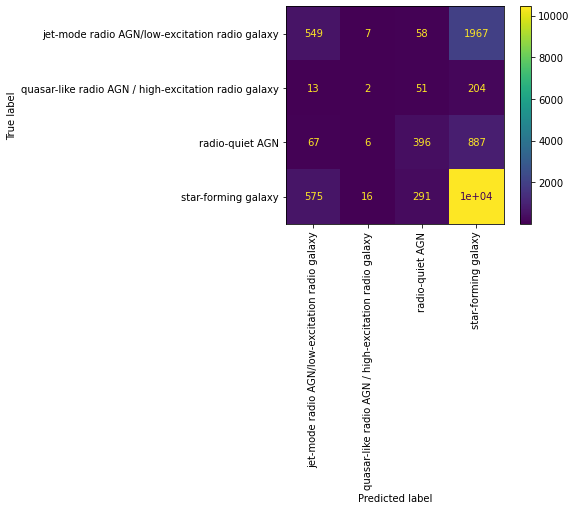

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Flaml

In [96]:
from flaml import AutoML
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    automl = AutoML()
    automl.fit(X_train, y_train.to_numpy(), task="classification", metric='accuracy', 
                                estimator_list=['lgbm', 'xgboost', 'xgb_limitdepth'], time_budget=60, n_jobs=8, 
                                log_file_name='general.log')

[flaml.automl: 08-10 12:50:14] {2390} INFO - task = classification
[flaml.automl: 08-10 12:50:14] {2392} INFO - Data split method: stratified
[flaml.automl: 08-10 12:50:14] {2396} INFO - Evaluation method: holdout
[flaml.automl: 08-10 12:50:15] {2465} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 08-10 12:50:15] {2605} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth']
[flaml.automl: 08-10 12:50:15] {2897} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-10 12:50:15] {3025} INFO - Estimated sufficient time budget=3552s. Estimated necessary time budget=24s.
[flaml.automl: 08-10 12:50:15] {3072} INFO -  at 0.8s,	estimator lgbm's best error=0.2702,	best estimator lgbm's best error=0.2702
[flaml.automl: 08-10 12:50:15] {2897} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-10 12:50:15] {3072} INFO -  at 0.9s,	estimator lgbm's best error=0.2702,	best estimator lgbm's best error=0.2702
[flaml.automl: 08-10 12:50:15] {2897} INFO - 

[flaml.automl: 08-10 12:50:29] {2897} INFO - iteration 35, current learner xgboost
[flaml.automl: 08-10 12:50:31] {3072} INFO -  at 17.6s,	estimator xgboost's best error=0.1299,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:31] {2897} INFO - iteration 36, current learner xgb_limitdepth
[flaml.automl: 08-10 12:50:31] {3072} INFO -  at 17.7s,	estimator xgb_limitdepth's best error=0.1690,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:31] {2897} INFO - iteration 37, current learner xgb_limitdepth
[flaml.automl: 08-10 12:50:32] {3072} INFO -  at 17.8s,	estimator xgb_limitdepth's best error=0.1634,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:32] {2897} INFO - iteration 38, current learner xgb_limitdepth
[flaml.automl: 08-10 12:50:32] {3072} INFO -  at 17.9s,	estimator xgb_limitdepth's best error=0.1634,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:32] {2897} INFO - iteration 39, current learner

[flaml.automl: 08-10 12:50:49] {3072} INFO -  at 34.9s,	estimator xgboost's best error=0.1299,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:49] {2897} INFO - iteration 73, current learner xgb_limitdepth
[flaml.automl: 08-10 12:50:49] {3072} INFO -  at 35.0s,	estimator xgb_limitdepth's best error=0.1611,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:49] {2897} INFO - iteration 74, current learner lgbm
[flaml.automl: 08-10 12:50:49] {3072} INFO -  at 35.4s,	estimator lgbm's best error=0.1402,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:49] {2897} INFO - iteration 75, current learner lgbm
[flaml.automl: 08-10 12:50:49] {3072} INFO -  at 35.7s,	estimator lgbm's best error=0.1402,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:50:49] {2897} INFO - iteration 76, current learner xgb_limitdepth
[flaml.automl: 08-10 12:50:50] {3072} INFO -  at 35.8s,	estimator xgb_limitdepth's best error=0.1611,	best 

[flaml.automl: 08-10 12:51:12] {2897} INFO - iteration 109, current learner lgbm
[flaml.automl: 08-10 12:51:12] {3072} INFO -  at 58.6s,	estimator lgbm's best error=0.1384,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:51:12] {2897} INFO - iteration 110, current learner xgb_limitdepth
[flaml.automl: 08-10 12:51:13] {3072} INFO -  at 59.6s,	estimator xgb_limitdepth's best error=0.1400,	best estimator xgboost's best error=0.1299
[flaml.automl: 08-10 12:51:15] {3335} INFO - retrain xgboost for 1.2s
[flaml.automl: 08-10 12:51:15] {3342} INFO - retrained model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8996463471242705, colsample_bynode=1,
              colsample_bytree=0.9543238718507984, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.015825455677042223,
              max_delta_step=0, max_depth=0, max_leaves=766,
              min_child

In [97]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 31, 'max_leaves': 766, 'min_child_weight': 0.07186914710571614, 'learning_rate': 0.015825455677042223, 'subsample': 0.9048064340763577, 'colsample_bylevel': 0.8996463471242705, 'colsample_bytree': 0.9543238718507984, 'reg_alpha': 0.058048034813330374, 'reg_lambda': 3.8456187189552598, 'FLAML_sample_size': 55878}
Best accuracy on validation data: 0.8701
Training duration of best run: 1.224 s


In [98]:
y_pred = automl.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7863    0.6742    0.7259      2581
quasar-like radio AGN / high-excitation radio galaxy     0.4732    0.1963    0.2775       270
                                     radio-quiet AGN     0.6931    0.5029    0.5829      1356
                                 star-forming galaxy     0.8793    0.9491    0.9129     11315

                                            accuracy                         0.8513     15522
                                           macro avg     0.7080    0.5806    0.6248     15522
                                        weighted avg     0.8405    0.8513    0.8419     15522



C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Lightgbm

In [99]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=10000, 
                             class_weight="balanced",
                            early_stopping_round=50,
                             eta=0.3,
                            #verbose=-1,
                            #max_depth=8,
                            #min_data_in_leaf=512,
                            num_leaves=15,
                            )

In [100]:
lightbm.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], sample_weight=classes_weights)

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[1]	training's multi_logloss: 0.66157	valid_0's multi_logloss: 2.782
[2]	training's multi_logloss: 0.604765	valid_0's multi_logloss: 2.5534
[3]	training's multi_logloss: 0.561499	valid_0's multi_logloss: 2.38474
[4]	training's multi_logloss: 0.526965	valid_0's multi_logloss: 2.26837
[5]	training's multi_logloss: 0.499821	valid_0's multi_logloss: 2.18069
[6]	training's multi_logloss: 0.476965	valid_0's multi_logloss: 2.10991
[7]	training's multi_logloss: 0.455941	valid_0's multi_logloss: 2.0454
[8]	training's multi_logloss: 0.43737	valid_0's multi_logloss: 1.97701
[9]	training's multi_logloss: 0.421931	valid_0's multi_logloss: 1.93296
[10]	training's multi_logloss: 0.406464	valid_0's multi_logloss: 1.88222
[11]	training's multi_logloss: 0.393722	valid_0's multi_logloss: 1.84173
[12]	training's multi_logloss: 0.381829	valid_0's multi_logloss: 1.80328
[13]	training's multi_logloss: 0.3

[119]	training's multi_logloss: 0.124665	valid_0's multi_logloss: 0.963578
[120]	training's multi_logloss: 0.1239	valid_0's multi_logloss: 0.961444
[121]	training's multi_logloss: 0.123139	valid_0's multi_logloss: 0.958311
[122]	training's multi_logloss: 0.122251	valid_0's multi_logloss: 0.956261
[123]	training's multi_logloss: 0.121353	valid_0's multi_logloss: 0.953177
[124]	training's multi_logloss: 0.120633	valid_0's multi_logloss: 0.953307
[125]	training's multi_logloss: 0.119988	valid_0's multi_logloss: 0.95131
[126]	training's multi_logloss: 0.119409	valid_0's multi_logloss: 0.949489
[127]	training's multi_logloss: 0.118845	valid_0's multi_logloss: 0.946919
[128]	training's multi_logloss: 0.118263	valid_0's multi_logloss: 0.945008
[129]	training's multi_logloss: 0.11773	valid_0's multi_logloss: 0.942527
[130]	training's multi_logloss: 0.117197	valid_0's multi_logloss: 0.940883
[131]	training's multi_logloss: 0.116578	valid_0's multi_logloss: 0.939481
[132]	training's multi_loglos

[229]	training's multi_logloss: 0.0725562	valid_0's multi_logloss: 0.79888
[230]	training's multi_logloss: 0.0722946	valid_0's multi_logloss: 0.797673
[231]	training's multi_logloss: 0.0719936	valid_0's multi_logloss: 0.796248
[232]	training's multi_logloss: 0.0717117	valid_0's multi_logloss: 0.795284
[233]	training's multi_logloss: 0.0713385	valid_0's multi_logloss: 0.793833
[234]	training's multi_logloss: 0.0710652	valid_0's multi_logloss: 0.793214
[235]	training's multi_logloss: 0.0707554	valid_0's multi_logloss: 0.792855
[236]	training's multi_logloss: 0.0704036	valid_0's multi_logloss: 0.791493
[237]	training's multi_logloss: 0.070043	valid_0's multi_logloss: 0.790512
[238]	training's multi_logloss: 0.0697728	valid_0's multi_logloss: 0.790571
[239]	training's multi_logloss: 0.0694323	valid_0's multi_logloss: 0.790001
[240]	training's multi_logloss: 0.0691616	valid_0's multi_logloss: 0.788693
[241]	training's multi_logloss: 0.0689131	valid_0's multi_logloss: 0.78771
[242]	training'

[343]	training's multi_logloss: 0.0466579	valid_0's multi_logloss: 0.696861
[344]	training's multi_logloss: 0.0464615	valid_0's multi_logloss: 0.695876
[345]	training's multi_logloss: 0.0463325	valid_0's multi_logloss: 0.695045
[346]	training's multi_logloss: 0.0461742	valid_0's multi_logloss: 0.694014
[347]	training's multi_logloss: 0.0459625	valid_0's multi_logloss: 0.693876
[348]	training's multi_logloss: 0.045822	valid_0's multi_logloss: 0.693375
[349]	training's multi_logloss: 0.0456651	valid_0's multi_logloss: 0.691774
[350]	training's multi_logloss: 0.0454786	valid_0's multi_logloss: 0.690628
[351]	training's multi_logloss: 0.0453017	valid_0's multi_logloss: 0.689677
[352]	training's multi_logloss: 0.0451162	valid_0's multi_logloss: 0.689192
[353]	training's multi_logloss: 0.0449461	valid_0's multi_logloss: 0.688655
[354]	training's multi_logloss: 0.0447965	valid_0's multi_logloss: 0.688043
[355]	training's multi_logloss: 0.0446792	valid_0's multi_logloss: 0.687188
[356]	trainin

[454]	training's multi_logloss: 0.0323762	valid_0's multi_logloss: 0.622121
[455]	training's multi_logloss: 0.0322617	valid_0's multi_logloss: 0.621535
[456]	training's multi_logloss: 0.032173	valid_0's multi_logloss: 0.621386
[457]	training's multi_logloss: 0.032101	valid_0's multi_logloss: 0.621108
[458]	training's multi_logloss: 0.0320135	valid_0's multi_logloss: 0.620431
[459]	training's multi_logloss: 0.0319295	valid_0's multi_logloss: 0.619906
[460]	training's multi_logloss: 0.0318466	valid_0's multi_logloss: 0.619369
[461]	training's multi_logloss: 0.0317729	valid_0's multi_logloss: 0.618617
[462]	training's multi_logloss: 0.0316504	valid_0's multi_logloss: 0.617942
[463]	training's multi_logloss: 0.0315562	valid_0's multi_logloss: 0.617415
[464]	training's multi_logloss: 0.0314847	valid_0's multi_logloss: 0.617139
[465]	training's multi_logloss: 0.0314012	valid_0's multi_logloss: 0.616544
[466]	training's multi_logloss: 0.0313159	valid_0's multi_logloss: 0.615988
[467]	training

[568]	training's multi_logloss: 0.0237352	valid_0's multi_logloss: 0.56694
[569]	training's multi_logloss: 0.0236875	valid_0's multi_logloss: 0.566549
[570]	training's multi_logloss: 0.0236277	valid_0's multi_logloss: 0.566019
[571]	training's multi_logloss: 0.0235865	valid_0's multi_logloss: 0.565636
[572]	training's multi_logloss: 0.0235184	valid_0's multi_logloss: 0.565093
[573]	training's multi_logloss: 0.0234785	valid_0's multi_logloss: 0.564833
[574]	training's multi_logloss: 0.0234142	valid_0's multi_logloss: 0.564286
[575]	training's multi_logloss: 0.0233473	valid_0's multi_logloss: 0.56395
[576]	training's multi_logloss: 0.0232921	valid_0's multi_logloss: 0.563745
[577]	training's multi_logloss: 0.0232285	valid_0's multi_logloss: 0.563543
[578]	training's multi_logloss: 0.0231697	valid_0's multi_logloss: 0.563002
[579]	training's multi_logloss: 0.0231192	valid_0's multi_logloss: 0.56248
[580]	training's multi_logloss: 0.0230549	valid_0's multi_logloss: 0.562179
[581]	training'

[680]	training's multi_logloss: 0.0183436	valid_0's multi_logloss: 0.522934
[681]	training's multi_logloss: 0.0183071	valid_0's multi_logloss: 0.52272
[682]	training's multi_logloss: 0.0182697	valid_0's multi_logloss: 0.522255
[683]	training's multi_logloss: 0.0182393	valid_0's multi_logloss: 0.521897
[684]	training's multi_logloss: 0.0182033	valid_0's multi_logloss: 0.521621
[685]	training's multi_logloss: 0.0181648	valid_0's multi_logloss: 0.521144
[686]	training's multi_logloss: 0.0181401	valid_0's multi_logloss: 0.520925
[687]	training's multi_logloss: 0.0181054	valid_0's multi_logloss: 0.520582
[688]	training's multi_logloss: 0.0180764	valid_0's multi_logloss: 0.520334
[689]	training's multi_logloss: 0.0180303	valid_0's multi_logloss: 0.519883
[690]	training's multi_logloss: 0.0179901	valid_0's multi_logloss: 0.519531
[691]	training's multi_logloss: 0.0179554	valid_0's multi_logloss: 0.519222
[692]	training's multi_logloss: 0.0179198	valid_0's multi_logloss: 0.518922
[693]	trainin

[790]	training's multi_logloss: 0.0146023	valid_0's multi_logloss: 0.487149
[791]	training's multi_logloss: 0.0145673	valid_0's multi_logloss: 0.486658
[792]	training's multi_logloss: 0.0145394	valid_0's multi_logloss: 0.486308
[793]	training's multi_logloss: 0.0145141	valid_0's multi_logloss: 0.486001
[794]	training's multi_logloss: 0.0144788	valid_0's multi_logloss: 0.485695
[795]	training's multi_logloss: 0.0144465	valid_0's multi_logloss: 0.485478
[796]	training's multi_logloss: 0.0144136	valid_0's multi_logloss: 0.485061
[797]	training's multi_logloss: 0.0143875	valid_0's multi_logloss: 0.484769
[798]	training's multi_logloss: 0.0143631	valid_0's multi_logloss: 0.484385
[799]	training's multi_logloss: 0.0143443	valid_0's multi_logloss: 0.484146
[800]	training's multi_logloss: 0.0143093	valid_0's multi_logloss: 0.48364
[801]	training's multi_logloss: 0.0142738	valid_0's multi_logloss: 0.483369
[802]	training's multi_logloss: 0.0142448	valid_0's multi_logloss: 0.483128
[803]	trainin

[899]	training's multi_logloss: 0.0119443	valid_0's multi_logloss: 0.460014
[900]	training's multi_logloss: 0.0119183	valid_0's multi_logloss: 0.459802
[901]	training's multi_logloss: 0.0118901	valid_0's multi_logloss: 0.459416
[902]	training's multi_logloss: 0.0118603	valid_0's multi_logloss: 0.458906
[903]	training's multi_logloss: 0.0118379	valid_0's multi_logloss: 0.458525
[904]	training's multi_logloss: 0.011807	valid_0's multi_logloss: 0.458012
[905]	training's multi_logloss: 0.0117844	valid_0's multi_logloss: 0.457728
[906]	training's multi_logloss: 0.011764	valid_0's multi_logloss: 0.457314
[907]	training's multi_logloss: 0.0117441	valid_0's multi_logloss: 0.457125
[908]	training's multi_logloss: 0.0117248	valid_0's multi_logloss: 0.456906
[909]	training's multi_logloss: 0.0117069	valid_0's multi_logloss: 0.45662
[910]	training's multi_logloss: 0.011685	valid_0's multi_logloss: 0.45638
[911]	training's multi_logloss: 0.0116555	valid_0's multi_logloss: 0.455921
[912]	training's 

[1009]	training's multi_logloss: 0.00983444	valid_0's multi_logloss: 0.435713
[1010]	training's multi_logloss: 0.00982392	valid_0's multi_logloss: 0.435601
[1011]	training's multi_logloss: 0.00980318	valid_0's multi_logloss: 0.435323
[1012]	training's multi_logloss: 0.0097868	valid_0's multi_logloss: 0.435167
[1013]	training's multi_logloss: 0.0097682	valid_0's multi_logloss: 0.435013
[1014]	training's multi_logloss: 0.00974931	valid_0's multi_logloss: 0.434825
[1015]	training's multi_logloss: 0.00973066	valid_0's multi_logloss: 0.434683
[1016]	training's multi_logloss: 0.00971324	valid_0's multi_logloss: 0.434436
[1017]	training's multi_logloss: 0.0096929	valid_0's multi_logloss: 0.434163
[1018]	training's multi_logloss: 0.00968003	valid_0's multi_logloss: 0.433963
[1019]	training's multi_logloss: 0.00966816	valid_0's multi_logloss: 0.433889
[1020]	training's multi_logloss: 0.00965465	valid_0's multi_logloss: 0.433734
[1021]	training's multi_logloss: 0.00963688	valid_0's multi_logloss

[1115]	training's multi_logloss: 0.00826917	valid_0's multi_logloss: 0.418521
[1116]	training's multi_logloss: 0.00825546	valid_0's multi_logloss: 0.418343
[1117]	training's multi_logloss: 0.00824057	valid_0's multi_logloss: 0.418098
[1118]	training's multi_logloss: 0.00822962	valid_0's multi_logloss: 0.417983
[1119]	training's multi_logloss: 0.00821555	valid_0's multi_logloss: 0.417893
[1120]	training's multi_logloss: 0.00820363	valid_0's multi_logloss: 0.417819
[1121]	training's multi_logloss: 0.00818412	valid_0's multi_logloss: 0.417605
[1122]	training's multi_logloss: 0.00816792	valid_0's multi_logloss: 0.417427
[1123]	training's multi_logloss: 0.00815336	valid_0's multi_logloss: 0.417241
[1124]	training's multi_logloss: 0.00814286	valid_0's multi_logloss: 0.417071
[1125]	training's multi_logloss: 0.0081257	valid_0's multi_logloss: 0.416763
[1126]	training's multi_logloss: 0.00811453	valid_0's multi_logloss: 0.416569
[1127]	training's multi_logloss: 0.00810239	valid_0's multi_loglo

[1223]	training's multi_logloss: 0.00696793	valid_0's multi_logloss: 0.404086
[1224]	training's multi_logloss: 0.00695529	valid_0's multi_logloss: 0.404015
[1225]	training's multi_logloss: 0.00694311	valid_0's multi_logloss: 0.403932
[1226]	training's multi_logloss: 0.0069299	valid_0's multi_logloss: 0.403767
[1227]	training's multi_logloss: 0.0069176	valid_0's multi_logloss: 0.403603
[1228]	training's multi_logloss: 0.00690725	valid_0's multi_logloss: 0.403463
[1229]	training's multi_logloss: 0.00689712	valid_0's multi_logloss: 0.403253
[1230]	training's multi_logloss: 0.0068846	valid_0's multi_logloss: 0.403248
[1231]	training's multi_logloss: 0.00687577	valid_0's multi_logloss: 0.403089
[1232]	training's multi_logloss: 0.00686593	valid_0's multi_logloss: 0.403088
[1233]	training's multi_logloss: 0.00685665	valid_0's multi_logloss: 0.403004
[1234]	training's multi_logloss: 0.00684663	valid_0's multi_logloss: 0.402912
[1235]	training's multi_logloss: 0.00683561	valid_0's multi_logloss

[1331]	training's multi_logloss: 0.00592871	valid_0's multi_logloss: 0.393951
[1332]	training's multi_logloss: 0.00592033	valid_0's multi_logloss: 0.393761
[1333]	training's multi_logloss: 0.00591105	valid_0's multi_logloss: 0.393676
[1334]	training's multi_logloss: 0.00590404	valid_0's multi_logloss: 0.39363
[1335]	training's multi_logloss: 0.0058941	valid_0's multi_logloss: 0.393432
[1336]	training's multi_logloss: 0.00588674	valid_0's multi_logloss: 0.393406
[1337]	training's multi_logloss: 0.00587532	valid_0's multi_logloss: 0.393264
[1338]	training's multi_logloss: 0.00586551	valid_0's multi_logloss: 0.393134
[1339]	training's multi_logloss: 0.00585847	valid_0's multi_logloss: 0.393061
[1340]	training's multi_logloss: 0.00584944	valid_0's multi_logloss: 0.392972
[1341]	training's multi_logloss: 0.00584517	valid_0's multi_logloss: 0.392932
[1342]	training's multi_logloss: 0.00583543	valid_0's multi_logloss: 0.392828
[1343]	training's multi_logloss: 0.00582822	valid_0's multi_loglos

[1438]	training's multi_logloss: 0.00508063	valid_0's multi_logloss: 0.385863
[1439]	training's multi_logloss: 0.00507341	valid_0's multi_logloss: 0.385796
[1440]	training's multi_logloss: 0.00506654	valid_0's multi_logloss: 0.385664
[1441]	training's multi_logloss: 0.00506124	valid_0's multi_logloss: 0.385625
[1442]	training's multi_logloss: 0.0050541	valid_0's multi_logloss: 0.385523
[1443]	training's multi_logloss: 0.00504686	valid_0's multi_logloss: 0.385463
[1444]	training's multi_logloss: 0.00503817	valid_0's multi_logloss: 0.385483
[1445]	training's multi_logloss: 0.00503139	valid_0's multi_logloss: 0.385452
[1446]	training's multi_logloss: 0.00502459	valid_0's multi_logloss: 0.385343
[1447]	training's multi_logloss: 0.00501649	valid_0's multi_logloss: 0.385365
[1448]	training's multi_logloss: 0.00500977	valid_0's multi_logloss: 0.38535
[1449]	training's multi_logloss: 0.00500186	valid_0's multi_logloss: 0.385315
[1450]	training's multi_logloss: 0.00499597	valid_0's multi_loglos

[1544]	training's multi_logloss: 0.00435896	valid_0's multi_logloss: 0.380664
[1545]	training's multi_logloss: 0.00435286	valid_0's multi_logloss: 0.380547
[1546]	training's multi_logloss: 0.00434674	valid_0's multi_logloss: 0.380518
[1547]	training's multi_logloss: 0.00434093	valid_0's multi_logloss: 0.38051
[1548]	training's multi_logloss: 0.00433462	valid_0's multi_logloss: 0.380432
[1549]	training's multi_logloss: 0.00432854	valid_0's multi_logloss: 0.380345
[1550]	training's multi_logloss: 0.00432241	valid_0's multi_logloss: 0.380249
[1551]	training's multi_logloss: 0.00431749	valid_0's multi_logloss: 0.38034
[1552]	training's multi_logloss: 0.00431241	valid_0's multi_logloss: 0.380255
[1553]	training's multi_logloss: 0.00430756	valid_0's multi_logloss: 0.380197
[1554]	training's multi_logloss: 0.00430329	valid_0's multi_logloss: 0.38015
[1555]	training's multi_logloss: 0.00429387	valid_0's multi_logloss: 0.379975
[1556]	training's multi_logloss: 0.00428829	valid_0's multi_logloss

[1656]	training's multi_logloss: 0.0036946	valid_0's multi_logloss: 0.375005
[1657]	training's multi_logloss: 0.00368902	valid_0's multi_logloss: 0.374974
[1658]	training's multi_logloss: 0.00368273	valid_0's multi_logloss: 0.374892
[1659]	training's multi_logloss: 0.00367714	valid_0's multi_logloss: 0.374846
[1660]	training's multi_logloss: 0.00367172	valid_0's multi_logloss: 0.374769
[1661]	training's multi_logloss: 0.00366601	valid_0's multi_logloss: 0.374602
[1662]	training's multi_logloss: 0.00366183	valid_0's multi_logloss: 0.3746
[1663]	training's multi_logloss: 0.00365569	valid_0's multi_logloss: 0.374523
[1664]	training's multi_logloss: 0.00365087	valid_0's multi_logloss: 0.374522
[1665]	training's multi_logloss: 0.00364605	valid_0's multi_logloss: 0.37446
[1666]	training's multi_logloss: 0.0036403	valid_0's multi_logloss: 0.3744
[1667]	training's multi_logloss: 0.00363549	valid_0's multi_logloss: 0.374393
[1668]	training's multi_logloss: 0.00362949	valid_0's multi_logloss: 0.

[1765]	training's multi_logloss: 0.00316145	valid_0's multi_logloss: 0.371494
[1766]	training's multi_logloss: 0.00315574	valid_0's multi_logloss: 0.371432
[1767]	training's multi_logloss: 0.00315024	valid_0's multi_logloss: 0.371402
[1768]	training's multi_logloss: 0.00314543	valid_0's multi_logloss: 0.371364
[1769]	training's multi_logloss: 0.00314089	valid_0's multi_logloss: 0.371372
[1770]	training's multi_logloss: 0.00313585	valid_0's multi_logloss: 0.371367
[1771]	training's multi_logloss: 0.00313178	valid_0's multi_logloss: 0.371357
[1772]	training's multi_logloss: 0.00312461	valid_0's multi_logloss: 0.371296
[1773]	training's multi_logloss: 0.00311894	valid_0's multi_logloss: 0.371315
[1774]	training's multi_logloss: 0.00311272	valid_0's multi_logloss: 0.371271
[1775]	training's multi_logloss: 0.00310889	valid_0's multi_logloss: 0.371219
[1776]	training's multi_logloss: 0.00310531	valid_0's multi_logloss: 0.371258
[1777]	training's multi_logloss: 0.00310199	valid_0's multi_logl

[1875]	training's multi_logloss: 0.00269732	valid_0's multi_logloss: 0.36796
[1876]	training's multi_logloss: 0.00269341	valid_0's multi_logloss: 0.368025
[1877]	training's multi_logloss: 0.00269026	valid_0's multi_logloss: 0.368018
[1878]	training's multi_logloss: 0.00268686	valid_0's multi_logloss: 0.368018
[1879]	training's multi_logloss: 0.00268228	valid_0's multi_logloss: 0.368002
[1880]	training's multi_logloss: 0.00267832	valid_0's multi_logloss: 0.367964
[1881]	training's multi_logloss: 0.00267535	valid_0's multi_logloss: 0.368017
[1882]	training's multi_logloss: 0.00267105	valid_0's multi_logloss: 0.368111
[1883]	training's multi_logloss: 0.00266661	valid_0's multi_logloss: 0.368138
[1884]	training's multi_logloss: 0.00266285	valid_0's multi_logloss: 0.368221
[1885]	training's multi_logloss: 0.0026603	valid_0's multi_logloss: 0.368167
[1886]	training's multi_logloss: 0.00265745	valid_0's multi_logloss: 0.368201
[1887]	training's multi_logloss: 0.00265481	valid_0's multi_loglos

[1985]	training's multi_logloss: 0.0023126	valid_0's multi_logloss: 0.366612
[1986]	training's multi_logloss: 0.0023084	valid_0's multi_logloss: 0.366582
[1987]	training's multi_logloss: 0.00230568	valid_0's multi_logloss: 0.366633
[1988]	training's multi_logloss: 0.00230215	valid_0's multi_logloss: 0.366631
[1989]	training's multi_logloss: 0.00229898	valid_0's multi_logloss: 0.366674
[1990]	training's multi_logloss: 0.00229588	valid_0's multi_logloss: 0.366622
[1991]	training's multi_logloss: 0.00229312	valid_0's multi_logloss: 0.366585
[1992]	training's multi_logloss: 0.00229062	valid_0's multi_logloss: 0.366589
[1993]	training's multi_logloss: 0.00228824	valid_0's multi_logloss: 0.366638
[1994]	training's multi_logloss: 0.00228465	valid_0's multi_logloss: 0.366636
[1995]	training's multi_logloss: 0.00228123	valid_0's multi_logloss: 0.366531
[1996]	training's multi_logloss: 0.00227754	valid_0's multi_logloss: 0.366548
[1997]	training's multi_logloss: 0.00227378	valid_0's multi_loglos

[2093]	training's multi_logloss: 0.00198756	valid_0's multi_logloss: 0.365168
[2094]	training's multi_logloss: 0.00198486	valid_0's multi_logloss: 0.365275
[2095]	training's multi_logloss: 0.00198242	valid_0's multi_logloss: 0.365297
[2096]	training's multi_logloss: 0.00197909	valid_0's multi_logloss: 0.365234
[2097]	training's multi_logloss: 0.0019761	valid_0's multi_logloss: 0.365309
[2098]	training's multi_logloss: 0.00197272	valid_0's multi_logloss: 0.365317
[2099]	training's multi_logloss: 0.0019695	valid_0's multi_logloss: 0.365314
[2100]	training's multi_logloss: 0.00196671	valid_0's multi_logloss: 0.365306
[2101]	training's multi_logloss: 0.00196377	valid_0's multi_logloss: 0.36531
[2102]	training's multi_logloss: 0.00196124	valid_0's multi_logloss: 0.365292
[2103]	training's multi_logloss: 0.00195831	valid_0's multi_logloss: 0.365292
[2104]	training's multi_logloss: 0.00195601	valid_0's multi_logloss: 0.365298
[2105]	training's multi_logloss: 0.00195308	valid_0's multi_logloss

[2201]	training's multi_logloss: 0.00171115	valid_0's multi_logloss: 0.364805
[2202]	training's multi_logloss: 0.00170951	valid_0's multi_logloss: 0.364853
[2203]	training's multi_logloss: 0.00170624	valid_0's multi_logloss: 0.364919
[2204]	training's multi_logloss: 0.00170301	valid_0's multi_logloss: 0.364905
[2205]	training's multi_logloss: 0.0016998	valid_0's multi_logloss: 0.364885
[2206]	training's multi_logloss: 0.00169751	valid_0's multi_logloss: 0.364979
[2207]	training's multi_logloss: 0.00169539	valid_0's multi_logloss: 0.365033
[2208]	training's multi_logloss: 0.00169229	valid_0's multi_logloss: 0.365058
[2209]	training's multi_logloss: 0.00168955	valid_0's multi_logloss: 0.365051
[2210]	training's multi_logloss: 0.0016875	valid_0's multi_logloss: 0.365068
[2211]	training's multi_logloss: 0.0016862	valid_0's multi_logloss: 0.365075
[2212]	training's multi_logloss: 0.00168412	valid_0's multi_logloss: 0.365046
[2213]	training's multi_logloss: 0.00168182	valid_0's multi_logloss

LGBMClassifier(class_weight='balanced', early_stopping_round=50, eta=0.3,
               n_estimators=10000, num_class=4, num_leaves=15,
               objective='multiclass')

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [36]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7688    0.8865    0.8235      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5408    0.4667    0.5010       270
                                     radio-quiet AGN     0.6461    0.8414    0.7309      1356
                                 star-forming galaxy     0.9625    0.8971    0.9286     11315

                                            accuracy                         0.8830     15522
                                           macro avg     0.7295    0.7729    0.7460     15522
                                        weighted avg     0.8953    0.8830    0.8864     15522



[]

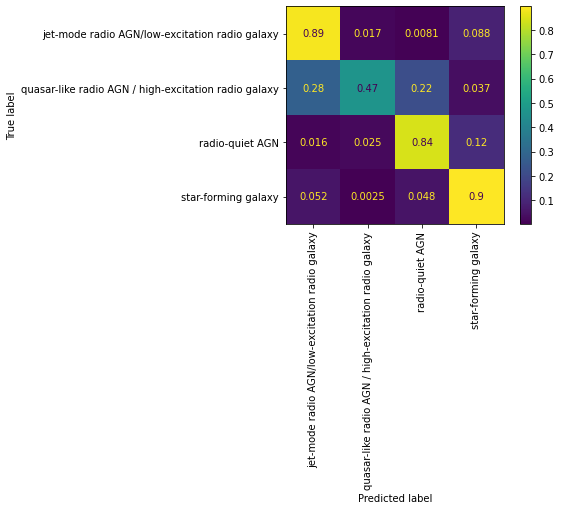

In [37]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [174]:
y_pred_xgb = model.predict(X_test)
y_pred_lgb = lightbm.predict(X_test)

In [175]:
y_pred_temp = y_pred_xgb.copy()
y_pred_temp[y_pred_temp==0] = 0
y_pred_temp[y_pred_lgb==0] = 0

In [176]:
print(classification_report(y_test, y_pred_temp, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7663    0.8842    0.8210      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5628    0.4148    0.4776       270
                                     radio-quiet AGN     0.7199    0.7942    0.7553      1356
                                 star-forming galaxy     0.9537    0.9144    0.9337     11315

                                            accuracy                         0.8902     15522
                                           macro avg     0.7507    0.7519    0.7469     15522
                                        weighted avg     0.8953    0.8902    0.8914     15522



# XGBoost

In [233]:
from sklearn.metrics import f1_score, recall_score
def xgb_f1(y, t):
    t = t.get_label()
    y = np.argmax(y, axis=1)
    
    return "f1", -f1_score(t, y, average='macro')

def xgb_recall(y, t):
    t = t.get_label()
    y = np.argmax(y, axis=1)
    
    return "f1", -recall_score(t, y, average='macro')

In [275]:
model = XGBClassifier(#use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=0.5,   
                      min_child_weight=3, 
                      reg_lambda=3,
                      eta=0.3, # Remember to reduce to 0.1 or 0.05 for better results
                      tree_method='hist', # exact is more precies, but this is much faster
                      objective='multi:softprob',
                      metric=['merror']
                      nthread=8,
                      n_estimators=8000,
                      )

In [276]:
bst = model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test )], 
                early_stopping_rounds=50,
                verbose=True, 
                #eval_metric=xgb_recall
                #sample_weight=classes_weights,
               ) # Maybe remove weight

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Loc

[0]	validation_0-mlogloss:0.99919	validation_1-mlogloss:1.01188
[1]	validation_0-mlogloss:0.78460	validation_1-mlogloss:0.80665
[2]	validation_0-mlogloss:0.64347	validation_1-mlogloss:0.67317
[3]	validation_0-mlogloss:0.54387	validation_1-mlogloss:0.58029
[4]	validation_0-mlogloss:0.47186	validation_1-mlogloss:0.51477
[5]	validation_0-mlogloss:0.41692	validation_1-mlogloss:0.46615
[6]	validation_0-mlogloss:0.37507	validation_1-mlogloss:0.42991
[7]	validation_0-mlogloss:0.34213	validation_1-mlogloss:0.40166
[8]	validation_0-mlogloss:0.31576	validation_1-mlogloss:0.37997
[9]	validation_0-mlogloss:0.29377	validation_1-mlogloss:0.36305
[10]	validation_0-mlogloss:0.27565	validation_1-mlogloss:0.34948
[11]	validation_0-mlogloss:0.25959	validation_1-mlogloss:0.33792
[12]	validation_0-mlogloss:0.24643	validation_1-mlogloss:0.32898
[13]	validation_0-mlogloss:0.23583	validation_1-mlogloss:0.32193
[14]	validation_0-mlogloss:0.22624	validation_1-mlogloss:0.31589
[15]	validation_0-mlogloss:0.21682	

[126]	validation_0-mlogloss:0.03986	validation_1-mlogloss:0.26555
[127]	validation_0-mlogloss:0.03948	validation_1-mlogloss:0.26561
[128]	validation_0-mlogloss:0.03916	validation_1-mlogloss:0.26571
[129]	validation_0-mlogloss:0.03870	validation_1-mlogloss:0.26584
[130]	validation_0-mlogloss:0.03809	validation_1-mlogloss:0.26604
[131]	validation_0-mlogloss:0.03759	validation_1-mlogloss:0.26633
[132]	validation_0-mlogloss:0.03724	validation_1-mlogloss:0.26640
[133]	validation_0-mlogloss:0.03680	validation_1-mlogloss:0.26666
[134]	validation_0-mlogloss:0.03662	validation_1-mlogloss:0.26672
[135]	validation_0-mlogloss:0.03602	validation_1-mlogloss:0.26683
[136]	validation_0-mlogloss:0.03562	validation_1-mlogloss:0.26696
[137]	validation_0-mlogloss:0.03521	validation_1-mlogloss:0.26714
[138]	validation_0-mlogloss:0.03487	validation_1-mlogloss:0.26721
[139]	validation_0-mlogloss:0.03446	validation_1-mlogloss:0.26737
[140]	validation_0-mlogloss:0.03408	validation_1-mlogloss:0.26747


In [277]:
y_pred = model.predict(X_test)
y_pred[y_pred>3]=3
y_pred[y_pred<0]=0
print(classification_report(y_test, np.rint(y_pred), target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8680    0.7947    0.8297      2581
quasar-like radio AGN / high-excitation radio galaxy     0.7163    0.3741    0.4915       270
                                     radio-quiet AGN     0.7949    0.7117    0.7510      1356
                                 star-forming galaxy     0.9232    0.9631    0.9428     11315

                                            accuracy                         0.9029     15522
                                           macro avg     0.8256    0.7109    0.7537     15522
                                        weighted avg     0.8992    0.9029    0.8994     15522



In [82]:
bst.save_model('combined_xgboost.json')

In [18]:
errors_test = bst.evals_result()['validation_0']['merror']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['merror']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('Error rate')
plt.legend()
plt.plot()

KeyError: 'merror'

In [ ]:
errors_test = bst.evals_result()['validation_0']['auc']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['auc']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('AUC')
plt.legend()
plt.plot()

In [28]:
2**13

8192

In [13]:
cross_val_model = XGBClassifier(use_label_encoder=False, 
                      max_depth=9, 
                      reg_alpha=0.5, 
                      min_child_weight=3, 
                      reg_lambda=3,
                      eta=0.1,
                      tree_method='hist', # exact is more precies, but this is much faster
                      objective='multi:softprob',
                      n_estimators=800,
                      )

In [123]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=512)

cv_score_xgb = cross_val_score(cross_val_model, X_train, y_train, cv=skf, n_jobs=64, scoring="accuracy")

In [124]:
print(cv_score_xgb)

[0.93442623 0.90163934 0.8852459  0.90163934 0.81967213 0.86065574
 0.92622951 0.92622951 0.91803279 0.89344262 0.8852459  0.8852459
 0.91803279 0.93442623 0.91803279 0.86065574 0.90163934 0.93442623
 0.90163934 0.90163934 0.87704918 0.86885246 0.93442623 0.92622951
 0.90163934 0.90983607 0.87704918 0.8852459  0.89344262 0.87704918
 0.90983607 0.90163934 0.92622951 0.90163934 0.91803279 0.8852459
 0.90983607 0.89344262 0.8852459  0.86885246 0.90163934 0.85245902
 0.90983607 0.8852459  0.86065574 0.90983607 0.90163934 0.91803279
 0.89344262 0.86885246 0.93442623 0.92622951 0.91803279 0.90163934
 0.91803279 0.89344262 0.90983607 0.81967213 0.92622951 0.93442623
 0.90983607 0.95081967 0.91803279 0.92622951 0.86065574 0.94262295
 0.90983607 0.91803279 0.90983607 0.91803279 0.87704918 0.90163934
 0.87704918 0.91803279 0.86885246 0.91803279 0.86065574 0.8852459
 0.89344262 0.89344262 0.83606557 0.8442623  0.91803279 0.8852459
 0.92622951 0.94262295 0.90983607 0.90163934 0.92622951 0.87704918

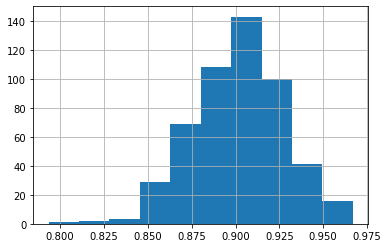

In [125]:
plt.hist(cv_score_xgb, bins=10)
plt.grid()

In [126]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.90089 ± 0.02438


Cross-validated Accuracy: 0.90071 ± 0.0243

ValueError: Feature shape mismatch, expected: 15, got 27

In [106]:
y_train.value_counts()

Classification
3                 45325
0                 10186
2                  5514
1                  1062
dtype: int64

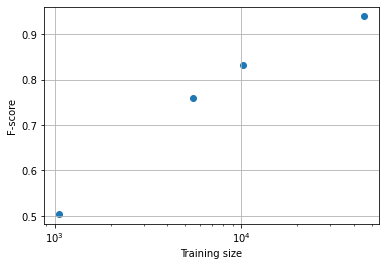

In [180]:
class_sizes = np.array([10186, 1062, 5514, 45325])
F_scores = np.array([0.8312, 0.5041, 0.7597, 0.9387])
plt.scatter(class_sizes, F_scores)
plt.xlabel("Training size")
plt.ylabel("F-score")
plt.grid()
plt.xscale("log")
plt.savefig("Sample_sizes.pdf")

In [16]:
test = [0.99 for i in range(99)]
test.append(0.01)
print("Data:", round(np.mean(test), 5), "±", round(np.std(test), 5))

Data: 0.9802 ± 0.09751


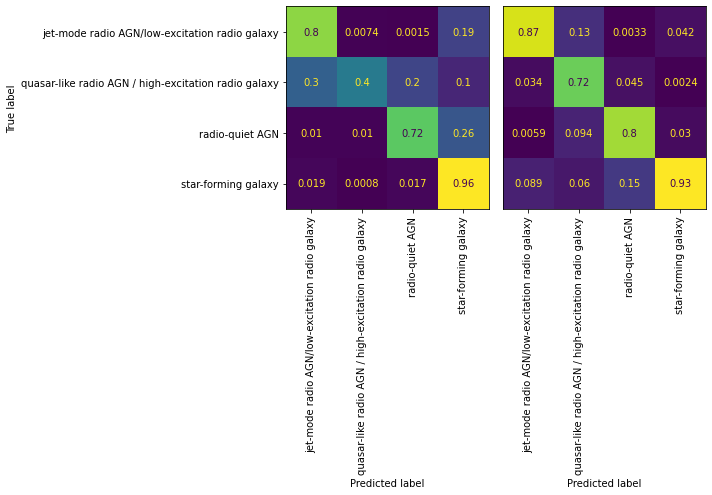

In [198]:
fig, axes = plt.subplots(1,2, figsize=(10,10))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[0], colorbar=False)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[1], colorbar=False)
axes[1].axes.get_yaxis().set_visible(False)
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.tight_layout()
plt.plot()
fig.savefig("Confusion.pdf")

## Redshift dependence

In [14]:
redshifts = X.iloc[X_train['Z_BEST'].index]['Z_BEST']

<AxesSubplot:>

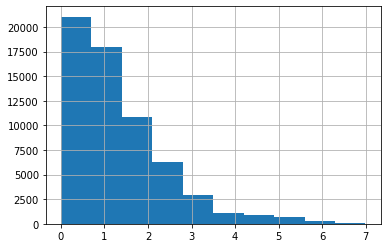

In [15]:
redshifts.hist()

In [43]:
accuracy_for_z_larger = []
accuracy_for_z_larger_std = []
z_range = [0,1,2,3,4]
for z in z_range:
    cv_score = cross_val_score(cross_val_model, X_train[redshifts>z], y_train[redshifts>z], cv=8, n_jobs=-1, scoring="accuracy")
    
    accuracy_for_z_larger.append(np.mean(cv_score))
    accuracy_for_z_larger_std.append(np.std(cv_score))

<ErrorbarContainer object of 3 artists>

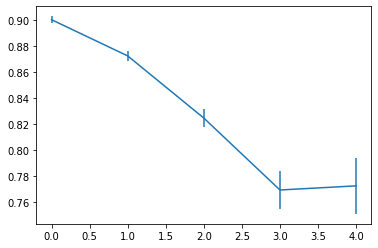

In [44]:
plt.errorbar(z_range, accuracy_for_z_larger, yerr=accuracy_for_z_larger_std)

In [17]:
accuracy_for_z_inbetween = []
accuracy_for_z_inbetween_std = []
z_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
for z in z_range:
    print(f"Working on redshift range {z}-{z+0.5}")
    filt = ((redshifts>z) & (redshifts<(z+0.5)))
    cv_score = cross_val_score(cross_val_model, X_train[filt], y_train[filt], cv=64, n_jobs=8, scoring="accuracy")
    
    accuracy_for_z_inbetween.append(np.mean(cv_score))
    accuracy_for_z_inbetween_std.append(np.std(cv_score))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
Working on redshift range 0.0-0.1
Working on redshift range 0.1-0.2
Working on redshift range 0.2-0.30000000000000004
Working on redshift range 0.30000000000000004-0.4
Working on redshift range 0.4-0.5
Working on redshift range 0.5-0.6
Working on redshift range 0.6000000000000001-0.7000000000000001
Working on redshift range 0.7000000000000001-0.8
Working on redshift range 0.8-0.9
Working on redshift range 0.9-1.0
Working on redshift range 1.0-1.1
Working on redshift range 1.1-1.2000000000000002
Working on redshift range 1.2000000000000002-1.3000000000000003
Working on redshift range 1.3-1.4000000000000001
Working on redshift range 1.4000000000000001-1.5000000000000002
Working on redshift range 1.5-1.6
Working on redshift range 1.6-1.7000000000000002
Working on redshift range 1.7000

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.3000000000000003-3.4000000000000004


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.4000000000000004-3.5000000000000004


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.5-3.6
Working on redshift range 3.6-3.7


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.7-3.8000000000000003


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.8000000000000003-3.9000000000000004


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.9000000000000004-4.0


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.0-4.1


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.1000000000000005-4.2


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.2-4.3


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

Working on redshift range 4.3-4.3999999999999995
Working on redshift range 4.4-4.5


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.5-4.6


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.6000000000000005-4.7


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.7-4.8


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.800000000000001-4.9


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

Working on redshift range 4.9-5.0
Working on redshift range 5.0-5.1


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(


In [ ]:
counts = []
z_range_counts = np.linspace(0,5,100)
for z in z_range_counts:
    filt = ((redshifts>z) & (redshifts<(z+0.5)))
    counts.append(len(X_train[filt]))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(z_range, accuracy_for_z_inbetween, yerr=accuracy_for_z_inbetween_std, width=0.5, label='Accuracy')
ax.set_ylim(0.6,1)


ax.set_xticks(np.arange(-0.25,5.5,0.5))
ax.set_xticklabels(np.arange(0, 6, 0.5))
ax.grid()
ax.set_xlabel("Redshift")
ax.set_ylabel("Accuracy")


ax2=ax.twinx()
ax2.plot(z_range_counts, counts, c='r', label='Counts')
ax2.set_ylabel("Counts")
fig.legend()
plt.show()
fig.savefig("Redshifts.pdf")

In [76]:
accuracy_for_z_plus_1 = []
z_range = np.linspace(0,6,100)
for z in z_range:
    y_pred = model.predict(X_test[(redshifts_test>z) & (redshifts_test<(z+1))])
    accuracy_for_z_plus_1.append(accuracy_score(y_test[((redshifts_test>z) & (redshifts_test<(z+1)))], y_pred))

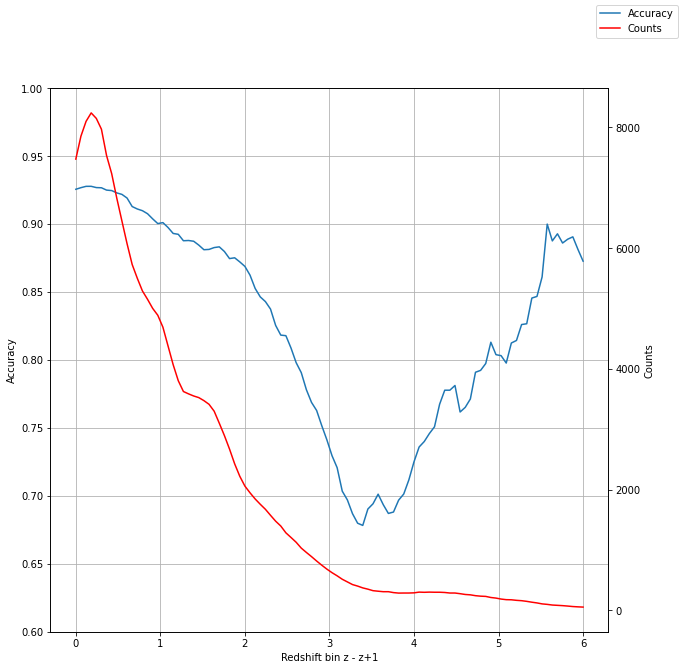

In [98]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(z_range, accuracy_for_z_plus_1, label='Accuracy')
ax.grid()
ax.set_xlabel("Redshift bin z - z+1")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.6,1)

ax2=ax.twinx()
ax2.plot(z_range, counts, c='r', label='Counts')
ax2.set_ylabel("Counts")
#ax2.xscale('log')
fig.legend()

## Feature relevance

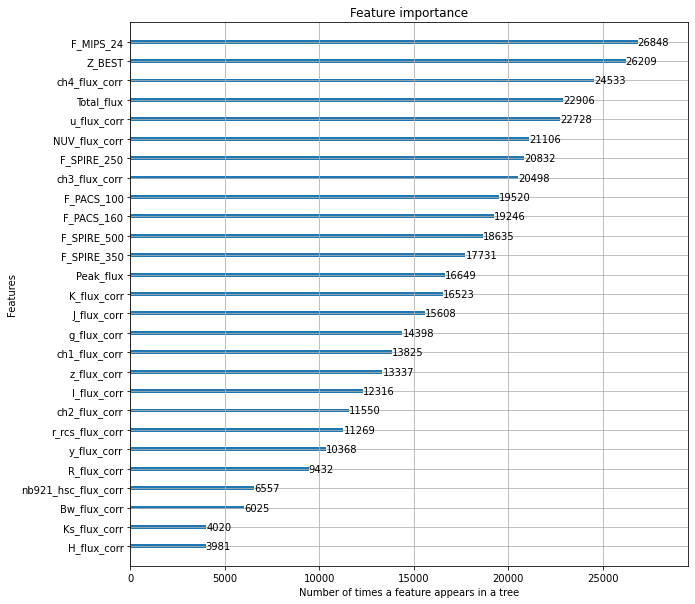

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax, importance_type='weight', xlabel='Number of times a feature appears in a tree')
fig.savefig("Feature_importance.pdf")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Average gain of splits which use the feature', ylabel='Features'>

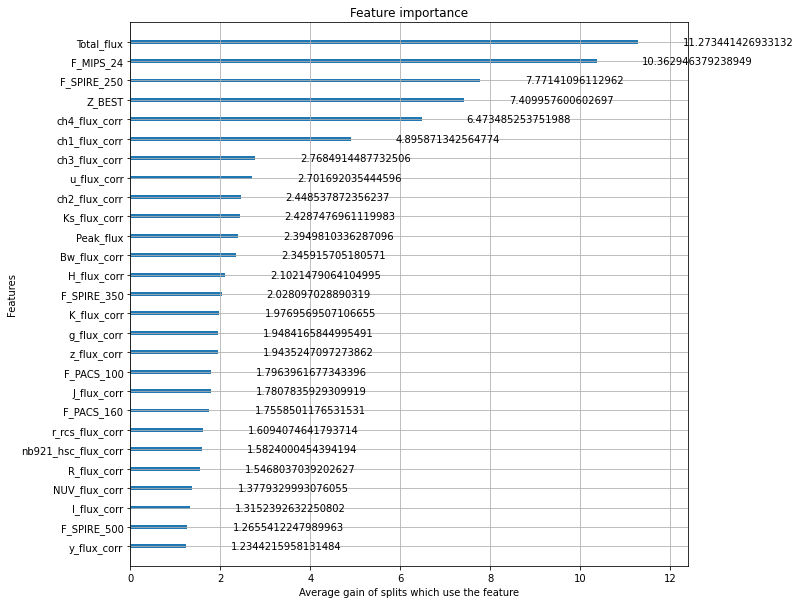

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax, importance_type='gain', xlabel='Average gain of splits which use the feature')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Average number of samples affected by the split by feature', ylabel='Features'>

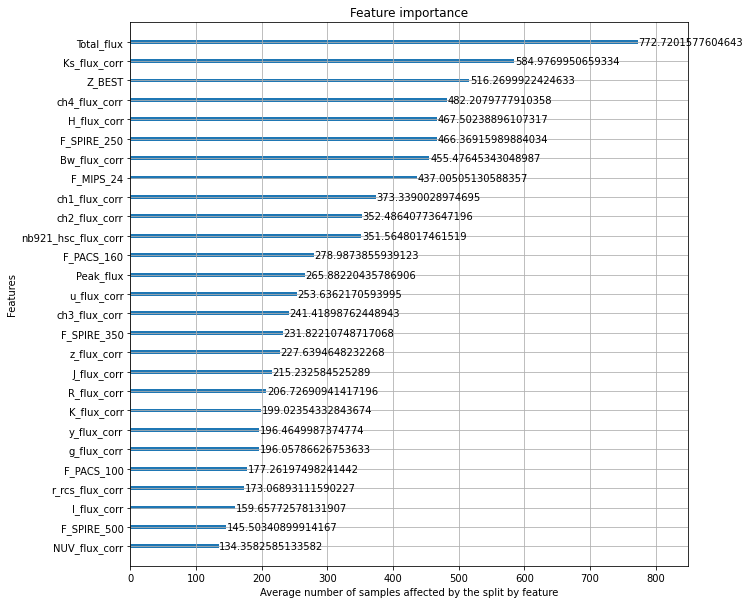

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax, importance_type='cover'
                    , xlabel='Average number of samples affected by the split by feature')

## Flag marking

In [215]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Prediction'])

In [216]:
Xray_all = []
opt_spec_all = []
ext_radio_all = []
IR_all = []
for j in range(4):
    for i in range(4):
        # Finding pandas dataframes for the squares in the confusion matrix
        cm_square = y_pred[(y_test['Classification']==j) & (y_pred['Prediction']==i)]
        flags = y_test_flags.loc[cm_square.index]

        # Finding frequencies of flags
        Xray_freq = sum(flags['Xray'])/len(flags['Xray'])
        opt_spec_freq = sum(flags['Opt_spec'])/len(flags['Opt_spec'])
        ext_radio_freq = sum(flags['Extended_radio'])/len(flags['Extended_radio'])
        IR_freq = sum(flags['IRAGN'])/len(flags['IRAGN'])

        Xray_all.append(Xray_freq)
        opt_spec_all.append(opt_spec_freq)
        ext_radio_all.append(ext_radio_freq)
        IR_all.append(IR_freq)

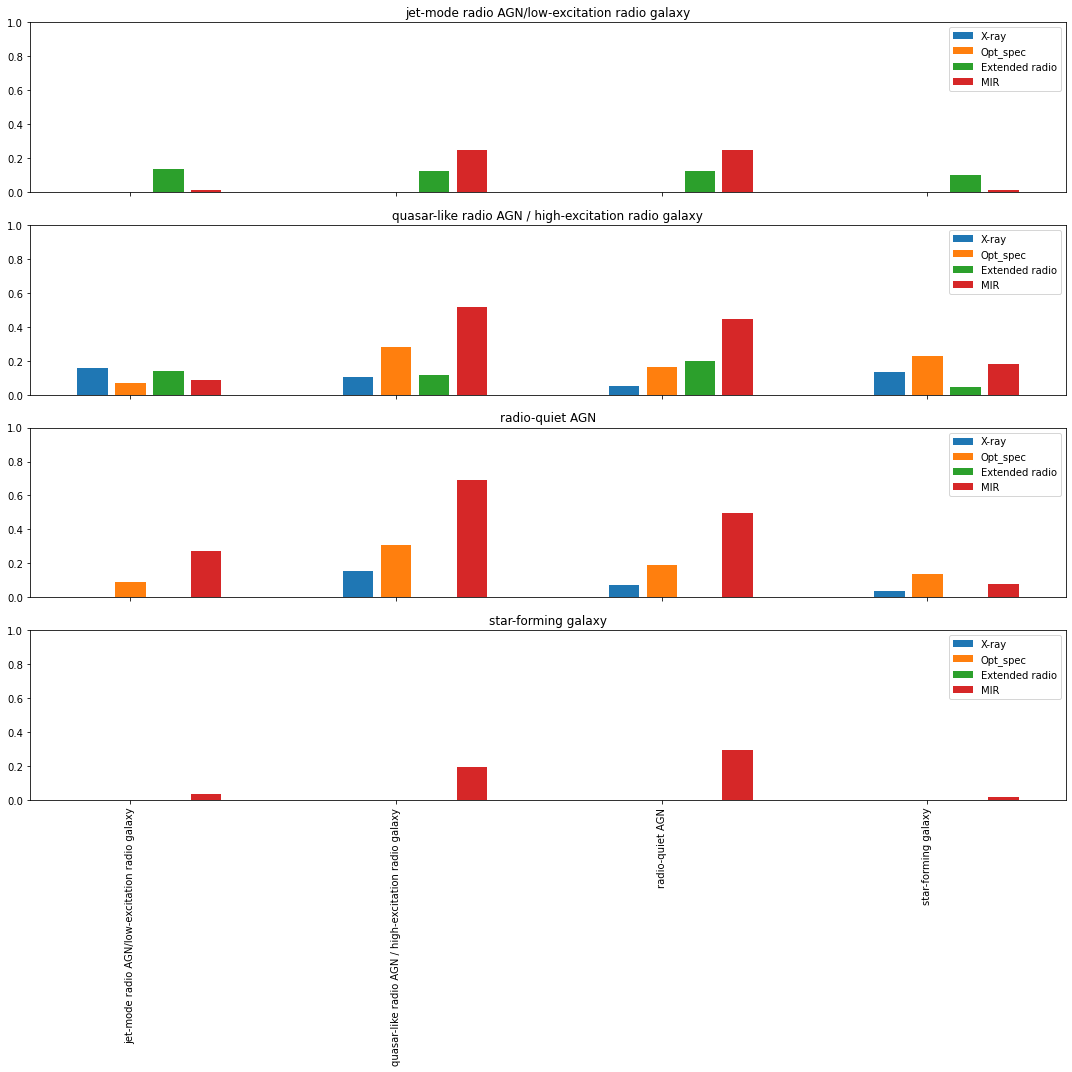

In [217]:
x = np.arange(0,26,7)
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex='all')
for i, ax in enumerate(axes):
    i0 = i*4
    i1 = (i+1)*4
    
    ax.bar(x, Xray_all[i0:i1], label='X-ray')
    # For setting the tick labels
    ax.bar(x+1, opt_spec_all[i0:i1], label='Opt_spec', tick_label=labels)
    ax.bar(x+2, ext_radio_all[i0:i1], label='Extended radio')
    ax.bar(x+3, IR_all[i0:i1], label='MIR')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(f'{labels[i]}')
    ax.set_ylim(0,1)
    ax.legend()
plt.tight_layout()
fig.savefig('Flags.pdf')

# DNN

In [23]:
y_train.to_numpy().flatten()

array([2, 3, 2, ..., 1, 3, 0])

In [24]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.to_numpy().flatten())
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [25]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

In [26]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [27]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

In [28]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1000,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight_dic,
)

Epoch 1/1000
1941/1941 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.1641 - val_loss: nan - val_accuracy: 0.1663
Epoch 2/1000
1917/1941 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.1642


KeyboardInterrupt

